# Compute mean continuum using the old formalism to compare results

## Step 0:  Load tests spectra

In [35]:
from configparser import ConfigParser
from picca.delta_extraction.astronomical_objects.forest import Forest
from picca.delta_extraction.data_catalogues.desi_healpix import DesiHealpix, defaults

PICCA_TEST_DIR = "$PICCA/py/picca/tests/delta_extraction"

config = ConfigParser()
config.read_dict({"data": {
    "catalogue": f"{PICCA_TEST_DIR}/data/QSO_cat_fuji_dark_healpix.fits.gz",
    "keep surveys": "all",
    "input directory": f"{PICCA_TEST_DIR}/data/",
    "out dir": f"{PICCA_TEST_DIR}/results/",
    "num processors": 1,
    "analysis type": "BAO 3D"
}})
for key, value in defaults.items():
    if key not in config["data"]:
        config["data"][key] = str(value)

data_old = DesiHealpix(config["data"])

print("Number of objects in the catalogue:", len(data_old.forests))

Number of objects in the catalogue: 63


## Step 1: Compute initial estimates of a_q and b_q for each forest

In [36]:
from scipy.interpolate import interp1d
from picca.delta_extraction.expected_fluxes.utils import compute_continuum

# Initial values for the eta, var_lss, and fudge parameters
# Initialisation is equivalent to the initialization in Dr16ExpectedFlux
num_bins_variance = 20
log_lambda_var_func_grid = np.log10(np.linspace(
    10**Forest.log_lambda_grid[0], 
    10**Forest.log_lambda_grid[-1], 
    num_bins_variance))
get_eta = interp1d(
    log_lambda_var_func_grid,
    np.ones_like(log_lambda_var_func_grid),
    fill_value='extrapolate',
    kind='cubic')
get_var_lss = interp1d(
    log_lambda_var_func_grid,
    np.zeros_like(log_lambda_var_func_grid) + 0.1,
    fill_value='extrapolate',
    kind='cubic')
get_fudge = interp1d(
    log_lambda_var_func_grid,
    np.zeros_like(log_lambda_var_func_grid),
    fill_value='extrapolate',
    kind='cubic')
get_mean_cont = interp1d(
    Forest.log_lambda_rest_frame_grid,
    np.ones_like(Forest.log_lambda_rest_frame_grid),
    fill_value="extrapolate")
use_constant_weight = False  # Use constant weight for the continuum fit
order = 1  # Order of the polynomial fit for the continuum

# get a_q and b_q estimates
continuum_fit_parameters = {}
for forest in data_old.forests: 
    cont_model, bad_continuum_reason, cont_fit_params = compute_continuum(
        forest, get_mean_cont, get_eta, get_var_lss, get_fudge, use_constant_weight, 
        order)
    
    forest.bad_continuum_reason = bad_continuum_reason
    forest.continuum = cont_model
    continuum_fit_parameters[forest.los_id] = cont_fit_params

/opt/anaconda3/lib/python3.12/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


## Step 2: Compute mean continuum

In [37]:
import numpy as np

var_lss_mod = 1.0
def compute_forest_weights(forest, continuum):
        """Compute the forest variance following du Mas des Bourboux 2020

        Arguments
        ---------
        forest: Forest
        A forest instance where the variance will be computed

        continuum: array of float
        Quasar continuum associated with the forest
        """
        w = forest.ivar > 0
        weights = np.empty_like(forest.log_lambda)
        weights[~w] = 0.0

        var_pipe = 1. / forest.ivar[w] / continuum[w]**2
        var_lss = get_var_lss(forest.log_lambda[w])
        eta = get_eta(forest.log_lambda[w])
        fudge = get_fudge(forest.log_lambda[w])
        weights[w] = 1.0/(
            eta * var_pipe + var_lss_mod*var_lss + fudge / var_pipe)

        return weights

mean_cont = np.zeros_like(Forest.log_lambda_rest_frame_grid)
mean_cont_weight = np.zeros_like(Forest.log_lambda_rest_frame_grid)

# first compute <F/C> in bins. C=Cont_old*spectrum_dependent_fitting_fct
# (and Cont_old is constant for all spectra in a bin), thus we actually
# compute
#    1/Cont_old * <F/spectrum_dependent_fitting_function>
for forest in data_old.forests:
    if forest.bad_continuum_reason is not None:
        continue
    bins = Forest.find_bins( # pylint: disable=not-callable
        forest.log_lambda - np.log10(1 + forest.z),
        Forest.log_lambda_rest_frame_grid)

    weights = compute_forest_weights(forest, forest.continuum)
    mean_cont += np.bincount(
        bins,
        weights=forest.continuum * weights,
        minlength=mean_cont.size)
    mean_cont_weight += np.bincount(
        bins,
        weights=weights,
        minlength=mean_cont.size)

w = mean_cont_weight > 0
mean_cont[w] /= mean_cont_weight[w]
mean_cont /= mean_cont[w].mean()
log_lambda_cont = Forest.log_lambda_rest_frame_grid[w]

# the new mean continuum is multiplied by the previous one to recover
# <F/spectrum_dependent_fitting_function>
new_cont = get_mean_cont(log_lambda_cont) * mean_cont[w]
get_mean_cont = interp1d(log_lambda_cont,
                         new_cont,
                         fill_value="extrapolate")
get_mean_cont_weight = interp1d(log_lambda_cont,
                                mean_cont_weight[w],
                                fill_value=0.0,
                                bounds_error=False)

mean_cont_old = get_mean_cont(Forest.log_lambda_rest_frame_grid)

# New formalism (lambda only)

In [38]:
import numpy as np
import numba

@numba.njit()
def interp_coeff(rf_wavelength, rf_wavelength_grid):
    """Compute the interpolation coefficients for a given rest-frame wavelength.

    Arguments
    ---------
    rf_wavelength: float
        Rest-frame wavelength in Angstroms
    rf_wavelength_grid: np.ndarray
        Rest-frame wavelength nodes where the interpolation is defined

    Returns
    -------
    coeff: np.ndarray
    Interpolation coefficients for the given rest-frame wavelength

    rf_wavelength_bin: int or np.ndarray
    Indices of the rf_wavelength bins for the given rf_wavelength value
    """
    rf_wavelength_bin = np.digitize(rf_wavelength, rf_wavelength_grid) - 1
    rf_wavelength_low = rf_wavelength_grid[rf_wavelength_bin]
    rf_wavelength_high = rf_wavelength_grid[rf_wavelength_bin + 1]

    coeff = (rf_wavelength_high - rf_wavelength) / (rf_wavelength_high - rf_wavelength_low)

    return coeff, rf_wavelength_bin

## Step 0: Load test spectra

In [39]:
from configparser import ConfigParser
from picca.delta_extraction.astronomical_objects.forest import Forest
from picca.delta_extraction.data_catalogues.desi_healpix import DesiHealpix, defaults

PICCA_TEST_DIR = "$PICCA/py/picca/tests/delta_extraction"

config = ConfigParser()
config.read_dict({"data": {
    "catalogue": f"{PICCA_TEST_DIR}/data/QSO_cat_fuji_dark_healpix.fits.gz",
    "keep surveys": "all",
    "input directory": f"{PICCA_TEST_DIR}/data/",
    "out dir": f"{PICCA_TEST_DIR}/results/",
    "num processors": 1,
    "analysis type": "BAO 3D"
}})
for key, value in defaults.items():
    if key not in config["data"]:
        config["data"][key] = str(value)

data_new = DesiHealpix(config["data"])

print("Number of objects in the catalogue:", len(data_new.forests))

Number of objects in the catalogue: 63


## Step 1: Compute initial estimates of a_q and b_q for each forest

In [40]:
from scipy.interpolate import interp1d
from picca.delta_extraction.expected_fluxes.utils import compute_continuum

# Initial values for the eta, var_lss, and fudge parameters
# Initialisation is equivalent to the initialization in Dr16ExpectedFlux
num_bins_variance = 20
log_lambda_var_func_grid = np.log10(np.linspace(
    10**Forest.log_lambda_grid[0], 
    10**Forest.log_lambda_grid[-1], 
    num_bins_variance))
get_eta = interp1d(
    log_lambda_var_func_grid,
    np.ones_like(log_lambda_var_func_grid),
    fill_value='extrapolate',
    kind='cubic')
get_var_lss = interp1d(
    log_lambda_var_func_grid,
    np.zeros_like(log_lambda_var_func_grid) + 0.1,
    fill_value='extrapolate',
    kind='cubic')
get_fudge = interp1d(
    log_lambda_var_func_grid,
    np.zeros_like(log_lambda_var_func_grid),
    fill_value='extrapolate',
    kind='cubic')
get_mean_cont = interp1d(
    Forest.log_lambda_rest_frame_grid,
    np.ones_like(Forest.log_lambda_rest_frame_grid),
    fill_value="extrapolate")
use_constant_weight = False  # Use constant weight for the continuum fit
order = 1  # Order of the polynomial fit for the continuum

# get a_q and b_q estimates
continuum_fit_parameters = {}
for forest in data_new.forests: 
    cont_model, bad_continuum_reason, cont_fit_params = compute_continuum(
        forest, get_mean_cont, get_eta, get_var_lss, get_fudge, use_constant_weight, 
        order)
    
    forest.bad_continuum_reason = bad_continuum_reason
    forest.continuum = cont_model
    continuum_fit_parameters[forest.los_id] = cont_fit_params

/opt/anaconda3/lib/python3.12/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


In [41]:
continuum_fit_parameters

{39633478723044513: (nan, nan, nan, 218),
 39633485232605672: (0.7239394650666104,
  1.0554037674739587,
  530.1126674116957,
  576),
 39633480916668425: (0.21921121622545228,
  -0.02287912547987965,
  -241.70526010916456,
  716),
 39633485245186634: (0.24986035581069482,
  -0.005879730589912365,
  147.36388892808338,
  715),
 39633487359116079: (0.5149807925213653,
  0.43992374880471435,
  363.9738683043372,
  709),
 39633483093511065: (0.08923189604275897,
  -0.03431866724710328,
  -1480.7055856116372,
  606),
 39633485232604190: (1.457043900077717,
  -0.8560556880389298,
  351.1606919621877,
  185),
 39633485240993119: (0.267601549502827,
  -0.1593618185573225,
  200.06015724356632,
  709),
 39633489464658242: (0.4589606448576034,
  0.19205148371170663,
  385.2757126905617,
  702),
 39633491536644232: (0.3868982814088713,
  -0.057862837240584754,
  -375.7405926659592,
  725),
 616094245882692041: (nan, nan, nan, 492),
 39633491540839435: (nan, nan, nan, 857),
 39633493583465214: (0.

# Step 2: Compute the mean continuum nodes

In [42]:
A_matrix = np.zeros(
    (Forest.log_lambda_rest_frame_grid.size, Forest.log_lambda_rest_frame_grid.size)
)
print("A_matrix.shape: ", A_matrix.shape)

B_matrix = np.zeros(Forest.log_lambda_rest_frame_grid.size)   
print("B_matrix.shape: ", B_matrix.shape)

for forest in data_new.forests:
    if forest.bad_continuum_reason is not None:
        continue

    log_lambda_rf = forest.log_lambda - np.log10(1 + forest.z)
    weights = compute_forest_weights(forest, forest.continuum)
    zero_point, slope, _, _ = continuum_fit_parameters[forest.los_id]

    coeffs, rf_wavelength_bin = interp_coeff(
        log_lambda_rf,
        Forest.log_lambda_rest_frame_grid)
    
    w = np.where(forest.continuum > 0)
    B_matrix[rf_wavelength_bin[w]] += weights[w] * coeffs[w] * forest.flux[w] / forest.continuum[w]
    w = np.where((forest.continuum > 0) & (rf_wavelength_bin < Forest.log_lambda_rest_frame_grid.size - 1))
    B_matrix[rf_wavelength_bin[w] + 1] += weights[w] * (1 - coeffs[w]) * forest.flux[w] / forest.continuum[w]

    try:
        A_matrix[rf_wavelength_bin, rf_wavelength_bin] += weights * coeffs * coeffs
        w = np.where(rf_wavelength_bin < Forest.log_lambda_rest_frame_grid.size - 1)
        A_matrix[rf_wavelength_bin[w] + 1, rf_wavelength_bin[w]] += weights[w] * coeffs[w] * (1 - coeffs[w])
        A_matrix[rf_wavelength_bin[w], rf_wavelength_bin[w] + 1] += weights[w] * coeffs[w] * (1 - coeffs[w])
        A_matrix[rf_wavelength_bin[w] + 1, rf_wavelength_bin[w] + 1] += weights[w] * (1 - coeffs[w]) * (1 - coeffs[w])

    except Exception as e:
        print("forest.los_id: ", forest.los_id)
        print("rf_wavelength_bin: ", rf_wavelength_bin)
        print("coeffs: ", coeffs)
        raise e
    

A_matrix.shape:  (201, 201)
B_matrix.shape:  (201,)


In [43]:
np.diag(A_matrix)

array([  0.77971249,  20.24443117,  23.72206313,  23.47955841,
        21.66907979,  22.69357071,  25.5344236 ,  24.04722173,
        24.92190705,  26.05057044,  26.65566557,  27.00748148,
        22.37376183,  25.58227748,  23.57561175,  26.37260684,
        27.22248028,  27.46275957,  26.76913605,  29.93523447,
        28.5797931 ,  28.18275487,  27.51737563,  30.57768608,
        30.73210688,  29.02599181,  26.67767629,  28.78831251,
        28.10407484,  29.94178967,  29.10111548,  29.92463338,
        30.43723902,  32.46405144,  30.29315637,  32.58261539,
        31.06079084,  36.14493458,  29.66088237,  31.33077149,
        31.15220459,  35.36800867,  31.03889996,  32.54477743,
        34.88958877,  33.35580853,  35.52936574,  35.32962673,
        34.62909357,  35.46846637,  34.68716493,  35.71101163,
        30.68338169,  32.74016491,  34.07580473,  36.52497204,
        33.84194925,  36.60306721,  37.85471571,  37.81544036,
        38.96975352,  40.77917407,  39.10920655,  42.61

In [44]:
w = np.diagonal(A_matrix) == 0
A_matrix[w, w] = 1.0

In [45]:
# Solve the linear system A_matrix * x = B_matrix
x = np.linalg.solve(A_matrix, B_matrix)


## Plot results and compare them with the old case

(-1.0, 2.0)

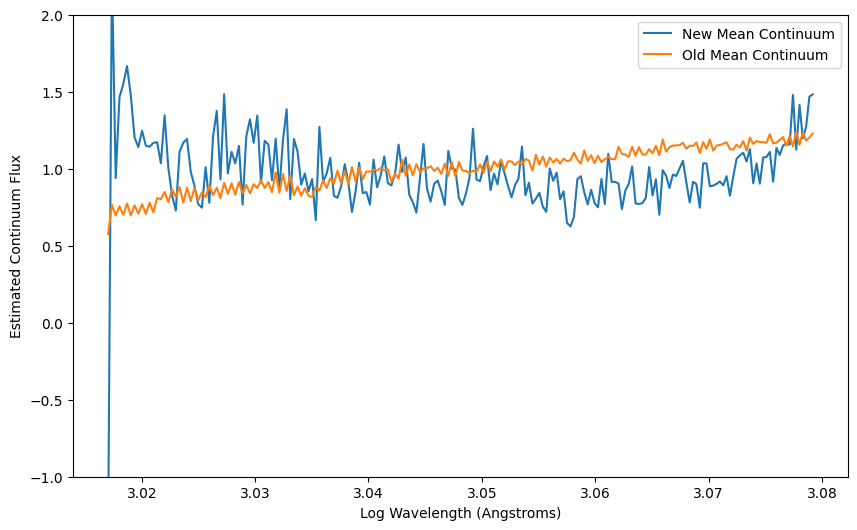

In [46]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_xlabel('Log Wavelength (Angstroms)')
ax.set_ylabel('Estimated Continuum Flux')
ax.plot(Forest.log_lambda_rest_frame_grid, x, label='New Mean Continuum')
ax.plot(Forest.log_lambda_rest_frame_grid, mean_cont_old, label='Old Mean Continuum')
ax.legend()
ax.set_ylim(-1, 2)


# New formalism (lambda + redshift)

## Step 0: Load test spectra

In [47]:
from configparser import ConfigParser
from picca.delta_extraction.astronomical_objects.forest import Forest
from picca.delta_extraction.data_catalogues.desi_healpix import DesiHealpix, defaults

PICCA_TEST_DIR = "$PICCA/py/picca/tests/delta_extraction"

config = ConfigParser()
config.read_dict({"data": {
    "catalogue": f"{PICCA_TEST_DIR}/data/QSO_cat_fuji_dark_healpix.fits.gz",
    "keep surveys": "all",
    "input directory": f"{PICCA_TEST_DIR}/data/",
    "out dir": f"{PICCA_TEST_DIR}/results/",
    "num processors": 1,
    "analysis type": "BAO 3D"
}})
for key, value in defaults.items():
    if key not in config["data"]:
        config["data"][key] = str(value)

data_new_2d = DesiHealpix(config["data"])

print("Number of objects in the catalogue:", len(data_new_2d.forests))

Number of objects in the catalogue: 63


## Step 1: Compute initial estimates of a_q and b_q for each forest

In [48]:
from scipy.interpolate import interp1d, RegularGridInterpolator
from picca.delta_extraction.expected_fluxes.utils import compute_continuum

from picca.delta_extraction.expected_fluxes.mean_continuum_interp_expected_flux import interp_coeff_lambda, interp_coeff_z

# Setup the redshift bins and centers
num_z_bins = 3
z_bins = np.linspace(2.1, 4.0, num_z_bins + 1)
z_centers = (z_bins[:-1] + z_bins[1:]) / 2



# Initial values for the eta, var_lss, and fudge parameters
# Initialisation is equivalent to the initialization in Dr16ExpectedFlux
num_bins_variance = 20
log_lambda_var_func_grid = np.log10(np.linspace(
    10**Forest.log_lambda_grid[0], 
    10**Forest.log_lambda_grid[-1], 
    num_bins_variance))
get_eta = interp1d(
    log_lambda_var_func_grid,
    np.ones_like(log_lambda_var_func_grid),
    fill_value='extrapolate',
    kind='cubic')
get_var_lss = interp1d(
    log_lambda_var_func_grid,
    np.zeros_like(log_lambda_var_func_grid) + 0.1,
    fill_value='extrapolate',
    kind='cubic')
get_fudge = interp1d(
    log_lambda_var_func_grid,
    np.zeros_like(log_lambda_var_func_grid),
    fill_value='extrapolate',
    kind='cubic')
mean_cont = np.ones(
    (z_bins.size - 1, Forest.log_lambda_rest_frame_grid.size))
get_mean_cont = RegularGridInterpolator(
    (z_centers, Forest.log_lambda_rest_frame_grid), 
    mean_cont, bounds_error=False, fill_value=0.0)
use_constant_weight = False  # Use constant weight for the continuum fit
order = 1  # Order of the polynomial fit for the continuum

# get a_q and b_q estimates
continuum_fit_parameters = {}
for forest in data_new_2d.forests: 
    cont_model, bad_continuum_reason, cont_fit_params = compute_continuum(
        forest, get_mean_cont, get_eta, get_var_lss, get_fudge, use_constant_weight, 
        order)
    
    forest.bad_continuum_reason = bad_continuum_reason
    forest.continuum = cont_model
    continuum_fit_parameters[forest.los_id] = cont_fit_params

/Users/iprafols/Documents/GitHub/picca/py/picca/delta_extraction/least_squares/least_squares_cont_model.py:190: RuntimeWarning: divide by zero encountered in divide
  var_pipe = 1. / forest.ivar[w] / cont_model[w]**2
/Users/iprafols/Documents/GitHub/picca/py/picca/delta_extraction/least_squares/least_squares_cont_model.py:195: RuntimeWarning: divide by zero encountered in divide
  weights[w] = 1.0 / cont_model[w]**2 / variance
/Users/iprafols/Documents/GitHub/picca/py/picca/delta_extraction/least_squares/least_squares_cont_model.py:195: RuntimeWarning: invalid value encountered in divide
  weights[w] = 1.0 / cont_model[w]**2 / variance
/opt/anaconda3/lib/python3.12/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


In [49]:
continuum_fit_parameters

{39633478723044513: (nan, nan, nan, 0),
 39633485232605672: (nan, nan, nan, 0),
 39633480916668425: (0.21921121622262565,
  -0.022879125476090396,
  -241.70526010916456,
  716),
 39633485245186634: (0.24986035581069482,
  -0.005879730589912365,
  147.36388892808338,
  715),
 39633487359116079: (0.5149807925211669,
  0.4399237488050771,
  363.9738683043373,
  709),
 39633483093511065: (nan, nan, nan, 0),
 39633485232604190: (nan, nan, nan, 0),
 39633485240993119: (0.2676015495011186,
  -0.15936181855496168,
  200.0601572435662,
  709),
 39633489464658242: (0.4589606448564233,
  0.19205148371359965,
  385.2757126905615,
  702),
 39633491536644232: (0.38689828140895194,
  -0.057862837240697663,
  -375.7405926659592,
  725),
 616094245882692041: (nan, nan, nan, 0),
 39633491540839435: (nan, nan, nan, 857),
 39633493583465214: (0.1926513206499509,
  0.2084427919968139,
  -884.7348046863099,
  787),
 39633491540838097: (0.22818148682295983,
  -0.023802016160615672,
  -538.0102853816593,
  79

# Step 2: Compute the mean continuum nodes

In [50]:
var_lss_mod = 1.0
def compute_forest_weights(forest, continuum):
        """Compute the forest variance following du Mas des Bourboux 2020

        Arguments
        ---------
        forest: Forest
        A forest instance where the variance will be computed

        continuum: array of float
        Quasar continuum associated with the forest
        """
        w = forest.ivar > 0
        weights = np.empty_like(forest.log_lambda)
        weights[~w] = 0.0

        var_pipe = 1. / forest.ivar[w] / continuum[w]**2
        var_lss = get_var_lss(forest.log_lambda[w])
        eta = get_eta(forest.log_lambda[w])
        fudge = get_fudge(forest.log_lambda[w])
        weights[w] = 1.0/(
            eta * var_pipe + var_lss_mod*var_lss + fudge / var_pipe)

        return weights

In [51]:

# for simplicity we introduce a new index 
# combined_bin = z_bin + N_z_bins * rf_wavelength_bin
# where z_bin is the index of the redshift bin and rf_wavelength_bin
# is the index of the rest-frame wavelength bin.
# This allows us to use a similar logic as in the 1D case.
matrix_size = num_z_bins * Forest.log_lambda_rest_frame_grid.size

A_matrix = np.zeros(
    (matrix_size, matrix_size)
)
B_matrix = np.zeros(matrix_size)   

for forest in data_new_2d.forests:
    if forest.bad_continuum_reason is not None:
        continue

    log_lambda_rf = forest.log_lambda - np.log10(1 + forest.z)
    weights = compute_forest_weights(forest, forest.continuum)
    rf_wavelength_coeffs, rf_wavelength_bin = interp_coeff_lambda(
        log_lambda_rf,
        Forest.log_lambda_rest_frame_grid)
    z_coeffs, z_bin = interp_coeff_z(
        forest.z,
        z_centers)
    #z_coeffs = np.repeat(z_coeffs, Forest.log_lambda_rest_frame_grid.size)
    
    # combined_bin is the index of the bin in the 2D matrix
    combined_bin = z_bin + num_z_bins * rf_wavelength_bin
    combined_bin_plus_wavelength = z_bin + num_z_bins * (rf_wavelength_bin + 1)
    combined_bin_plus_z = z_bin + 1 + num_z_bins * (rf_wavelength_bin)
    combined_bin_plus_both = z_bin + 1 + num_z_bins * (rf_wavelength_bin + 1)

    # Fill the B_matrix
    # diagonal elements
    w = np.where(forest.continuum > 0)
    B_matrix[combined_bin[w]] += weights[w] * z_coeffs * rf_wavelength_coeffs[w] * forest.flux[w] / forest.continuum[w]
    # off-diagonal elements
    w = np.where((forest.continuum > 0) & (combined_bin_plus_wavelength < matrix_size - 1))
    B_matrix[combined_bin_plus_wavelength[w] + 1] += weights[w] * z_coeffs * (1 - rf_wavelength_coeffs[w]) * forest.flux[w] / forest.continuum[w]
    w = np.where((forest.continuum > 0) & (combined_bin_plus_z < matrix_size - 1))
    B_matrix[combined_bin_plus_z[w] + 1] += weights[w] * (1 - z_coeffs) * rf_wavelength_coeffs[w] * forest.flux[w] / forest.continuum[w]
    w = np.where((forest.continuum > 0) & (combined_bin_plus_both < matrix_size - 1))
    B_matrix[combined_bin_plus_both[w] + 1] += weights[w] * (1 - z_coeffs) * (1 - rf_wavelength_coeffs[w]) * forest.flux[w] / forest.continuum[w]

    # Fill the A_matrix
    # diagonal elements
    A_matrix[combined_bin, combined_bin] += weights * z_coeffs * z_coeffs * rf_wavelength_coeffs * rf_wavelength_coeffs
    # off-diagonal elements
    w = np.where(combined_bin_plus_wavelength < matrix_size - 1)
    A_matrix[combined_bin_plus_wavelength[w], combined_bin[w]] += weights[w] * z_coeffs * z_coeffs * rf_wavelength_coeffs[w] * (1 - rf_wavelength_coeffs[w])
    A_matrix[combined_bin[w], combined_bin_plus_wavelength[w]] += weights[w] * z_coeffs * z_coeffs * rf_wavelength_coeffs[w] * (1 - rf_wavelength_coeffs[w])
    A_matrix[combined_bin_plus_wavelength[w], combined_bin_plus_wavelength[w]] += weights[w] * z_coeffs * z_coeffs * (1 - rf_wavelength_coeffs[w]) * (1 - rf_wavelength_coeffs[w])
    w = np.where(combined_bin_plus_z < matrix_size - 1)
    A_matrix[combined_bin_plus_z[w], combined_bin[w]] += weights[w] * z_coeffs * (1 - z_coeffs) * rf_wavelength_coeffs[w] * rf_wavelength_coeffs[w]
    A_matrix[combined_bin[w], combined_bin_plus_z[w]] += weights[w] * z_coeffs * (1 - z_coeffs) * rf_wavelength_coeffs[w] * rf_wavelength_coeffs[w]
    A_matrix[combined_bin_plus_z[w], combined_bin_plus_z[w]] += weights[w] * (1 - z_coeffs) * (1 - z_coeffs) * rf_wavelength_coeffs[w] * rf_wavelength_coeffs[w]
    w = np.where(combined_bin_plus_both < matrix_size - 1)
    A_matrix[combined_bin_plus_both[w], combined_bin[w]] += weights[w] * z_coeffs * (1 - z_coeffs) * rf_wavelength_coeffs[w] * (1 - rf_wavelength_coeffs[w])
    A_matrix[combined_bin[w], combined_bin_plus_both[w]] += weights[w] * z_coeffs * (1 - z_coeffs) * rf_wavelength_coeffs[w] * (1 - rf_wavelength_coeffs[w])
    A_matrix[combined_bin_plus_both[w], combined_bin_plus_both[w]] += weights[w] * (1 - z_coeffs) * (1 - z_coeffs) * (1 - rf_wavelength_coeffs[w]) * (1 - rf_wavelength_coeffs[w])


# Take care of unstable solutions
# If the diagonal of A_matrix is zero, we set it to 1.0
# This is a workaround for the case where there is no coverage
# for some wavelengths.
w = np.diagonal(A_matrix) == 0
A_matrix[w, w] = 1.0

# Solve the linear system A_matrix * mean_cont = B_matrix
mean_cont = np.linalg.solve(A_matrix, B_matrix)
# Undo the new indexing
mean_cont = mean_cont.reshape((num_z_bins, Forest.log_lambda_rest_frame_grid.size))


# update the interpolator with the mean continuum
get_mean_cont = RegularGridInterpolator(
    (z_centers, Forest.log_lambda_rest_frame_grid), 
    mean_cont, bounds_error=False, fill_value=0.0,
)


# Plot results and compare with previous cases

(-1.0, 2.0)

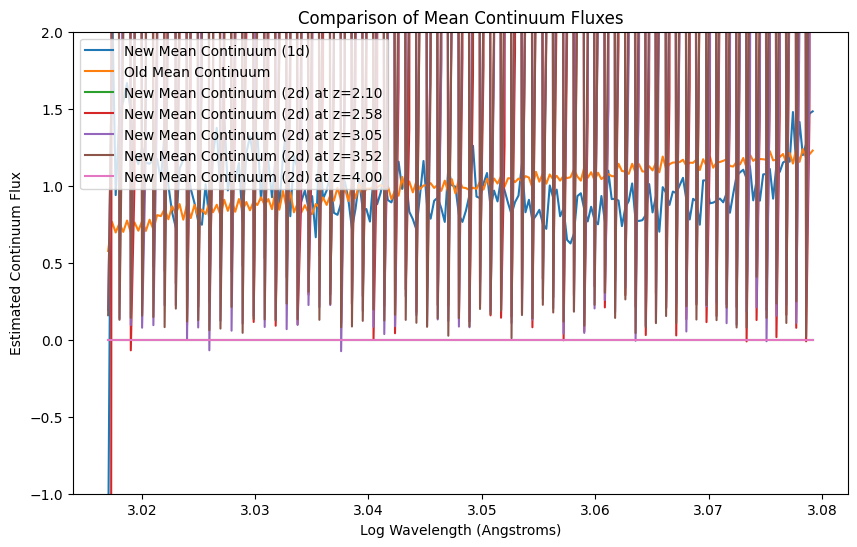

In [56]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_xlabel('Log Wavelength (Angstroms)')
ax.set_ylabel('Estimated Continuum Flux')
ax.plot(Forest.log_lambda_rest_frame_grid, x, label='New Mean Continuum (1d)')
ax.plot(Forest.log_lambda_rest_frame_grid, mean_cont_old, label='Old Mean Continuum')

for z in np.linspace(2.1, 4.0, 5):
    # Create a grid of points for the new mean continuum
    # at a specific redshift z
    # We use the log_lambda_rest_frame_grid and the redshift z
    points = np.column_stack([np.full_like(Forest.log_lambda_rest_frame_grid, z), Forest.log_lambda_rest_frame_grid])
    to_plot = get_mean_cont(points)
    ax.plot(Forest.log_lambda_rest_frame_grid, 
            to_plot, 
            label=f'New Mean Continuum (2d) at z={z:.2f}')
ax.set_title('Comparison of Mean Continuum Fluxes')
ax.legend()
ax.set_ylim(-1, 2)

